In [102]:
import torch
from torch import nn

import torch.functional as F

from PIL import Image
import torchvision.transforms.functional as TF

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import numpy as np
import random

import requests
import io

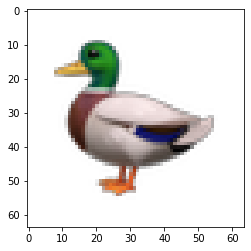

In [149]:
def load_image(url, max_size=48, padding=8):
    r = requests.get(url)
    img = Image.open(io.BytesIO(r.content))
    img.thumbnail((max_size, max_size), Image.ANTIALIAS)
    img = np.float32(img)/255.0
    img = np.pad(img,((8,8),(8,8),(0,0)))
    
    # premultiply RGB by Alpha
    img[..., :3] *= img[..., 3:]
    
    img = torch.Tensor(img).cuda()
    img = img.transpose(0,2)

    return img


def load_emoji(emoji):
    code = hex(ord(emoji))[2:].lower()
    url = 'https://raw.githubusercontent.com/iamcal/emoji-data/master/img-apple-64/%s.png' % code
    return load_image(url)


image = load_emoji("🦆")

plt.imshow(image.transpose(0,2).cpu())

In [207]:
class Automata(nn.Module):

    def __init__(self, grid_size, n_channels, seed_pos):

        super(Automata, self).__init__()

        self.n_channels = n_channels
        self.seed_pos = seed_pos
        self.grid_size = grid_size

        self.filters = torch.Tensor([[[[-1, 0, 1],
                                       [-2, 0, 2],
                                       [-1, 0, 1]
                                       ]],
                                     [[[-1, -2, -1],
                                       [0, 0, 0],
                                       [1, 2, 1]
                                       ]],
                                     [[[0, 0, 0],
                                       [0, 1, 0],
                                       [0, 0, 0]
                                       ]]]).cuda()

        self.mapper = nn.Sequential(
            nn.Linear(3*n_channels, 128),
            nn.ReLU(),
            nn.Linear(128, n_channels),
            nn.Tanh()
        )

        self.mapper[2].weight.data.fill_(0)
        self.mapper[2].bias.data.fill_(0)

    def perception(self, x):

        conved = nn.functional.pad(x, (1, 1, 1, 1), mode="reflect")
        conved = nn.functional.conv2d(conved, model.filters)
        conved = conved.view(1, 3*self.n_channels, -1)

        conved = conved.transpose(1, 2)
        conved = self.mapper(conved)

        conved = conved.transpose(1, 2)
        conved = conved.view(self.n_channels, 1, *self.grid_size)

        can_update = torch.rand_like(conved) < 0.75
        
        return conved*can_update

    def forward(self, x, iterations):
        
        model.history = torch.zeros(iterations, *x.shape)
        
        for i in range(iterations):

            conved = self.perception(x)

            x = x + conved

            is_alive = nn.functional.max_pool2d(
                x[3], (3, 3), stride=1, padding=1) > 0

            x = x*is_alive
            x[:4].clamp_(0, 1)
            
            model.history[i] = x

        return x

In [208]:
n_epochs = 2500

lr = 0.001

model = Automata((64, 64), 16, (32, 32)).cuda()

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

initial_state = torch.zeros(16, 1, 64, 64).cuda()
initial_state[3:, 0, 32, 32] = 1

losses = []

for i in range(n_epochs):
    
    iterations = random.randint(64,96)

    out = model(initial_state,iterations)[:4].squeeze()

    optimizer.zero_grad()

    loss = criterion(out, image)

    loss.backward()
    optimizer.step()

    if i % 100 == 0:
    
        print(i, float(loss.cpu().detach()))
        
    losses.append(loss)

0 0.10209284722805023
100 0.026805788278579712
200 0.014453653246164322
300 0.022534187883138657
400 0.013229960575699806
500 0.01372392475605011
600 0.010587673634290695
700 0.010725388303399086
800 0.010208848863840103
900 0.01141517423093319
1000 0.007231998257339001
1100 0.008791272528469563
1200 0.010590018704533577
1300 0.005043069366365671
1400 0.007365576922893524
1500 0.008666757494211197
1600 0.006638010963797569
1700 0.004798645153641701
1800 0.004240661859512329
1900 0.0035087326541543007
2000 0.004199202172458172
2100 0.005076095461845398
2200 0.0030097109265625477
2300 0.0036598278675228357
2400 0.003558133263140917


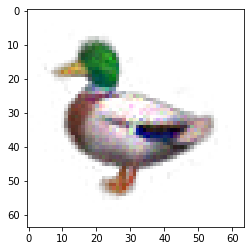

In [209]:

plt.imshow(out.transpose(0,2).cpu().detach())


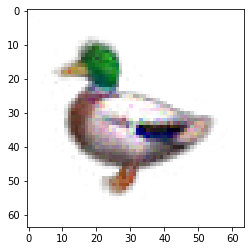

In [211]:
plt.imshow(model.history[64][:4,0].transpose(0,2).cpu().detach())